In [1]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpqzcy29/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpqzcy29/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)


In [2]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [3]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((100,64*64))
%matplotlib inline
for i in range(100):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    data2[i,:]=temp.reshape(-1)
#plt.imshow(XXX,'gray')

In [5]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

def gen_samples(n, nbatch=10):
    samples = []
    labels = []
    n_gen = 0
    for i in range(n/nbatch):
        #ymb = floatX(OneHot(np_rng.randint(0, 10, nbatch), ny))
        zmb = floatX(np_rng.uniform(-1., 1., size=(nbatch, nz)))
        xmb = _gen(zmb)
        samples.append(xmb)
        n_gen += len(xmb)
    n_left = n-n_gen
    #ymb = floatX(OneHot(np_rng.randint(0, 10, n_left), ny))
    zmb = floatX(np_rng.uniform(-1., 1., size=(n_left, nz)))
    xmb = _gen(zmb)
    samples.append(xmb)    
    #labels.append(np.argmax(ymb, axis=1))
    return np.concatenate(samples, axis=0)

In [ ]:
import sys
sys.path.append('..')

import os
import json
import scipy.io
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error

import math
import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import batchnorm, conv_cond_concat, deconv, dropout
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score


#image = scipy.io.loadmat('WB_test64_GAN.mat')
#data1=np.abs(image['WB_test64_GAN']-1)

vaX= data2[0:100]
trX= data2[0:100]

vaX = floatX(vaX)

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
#ny = 10           # # of classes
nbatch = 10      # # of examples in batch
npx = 64          # # of pixels width/height of images
nz = 100          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 40          # # of gen filters in first conv layer
ndf = 40          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 10000       # # of iter at starting learning rate
niter_decay = 1 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
#ntrain, nval, ntest = len(trX), len(vaX), len(teX)
ntrain = len(trX)

def transform(X):
    return (floatX(X)/255.).reshape(-1, nc, npx, npx)
    #return (floatX(X)).reshape(-1, nc, npx, npx)
def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X

relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()

bce = T.nnet.binary_crossentropy
tanh = activations.Tanh()

eifn = inits.Normal(scale=0.02)
gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)

#encoder
ew  = difn((ndf, nc, 5, 5), 'ew')
eg1 = gain_ifn((ndf), 'eg1')
eb1 = bias_ifn((ndf), 'eb1')
ew2 = difn((ndf*2, ndf, 5, 5), 'ew2')
eg2 = gain_ifn((ndf*2), 'eg2')
eb2 = bias_ifn((ndf*2), 'eb2')
ew3 = difn((ndf*4, ndf*2,5,5), 'ew3')
eg3 = gain_ifn((ndf*4), 'eg3')
eb3 = bias_ifn((ndf*4), 'eb3')
ew4 = difn((ndf*8, ndf*4, 5, 5), 'ew4')
eg4 = gain_ifn((ndf*8), 'eg4')
eb4 = bias_ifn((ndf*8), 'eb4')
bmu = bias_ifn((nz), 'bmu')
wmu = difn((ndf*8*4*4, nz), 'wmu')
bsigma = bias_ifn((nz), 'bsigma')
wsigma = difn((ndf*8*4*4, nz), 'wsigma')


#generator
gw  = gifn((nz, ngf*8*4*4), 'gw')
gg = gain_ifn((ngf*8*4*4),'gg')
gb = bias_ifn((ngf*8*4*4),'gb')
gw2 = gifn((ngf*8, ngf*4,5,5), 'gw2')
gg2 = gain_ifn((ngf*4), 'gg2')
gb2 = bias_ifn((ngf*4), 'gb2')
gw3 = gifn((ngf*4, ngf*2, 5, 5), 'gw3')
gg3 = gain_ifn((ngf*2), 'gg3')
gb3 = bias_ifn((ngf*2), 'gb3')
gw4 = gifn((ngf*2, ngf, 5, 5), 'gw4')
gg4 = gain_ifn((ngf), 'gg4')
gb4 = bias_ifn((ngf), 'gb4')
gwx = gifn((ngf, nc, 5, 5), 'gwx')

#discriminator
dw  = difn((ndf, nc, 5, 5), 'dw')
dw2 = difn((ndf*2, ndf, 5, 5), 'dw2')
dg2 = gain_ifn((ndf*2), 'dg2')
db2 = bias_ifn((ndf*2), 'db2')
dw3 = difn((ndf*4, ndf*2,5,5), 'dw3')
dg3 = gain_ifn((ndf*4), 'dg3')
db3 = bias_ifn((ndf*4), 'db3')
dw4 = difn((ndf*8, ndf*4, 5, 5), 'dw4')
dg4 = gain_ifn((ndf*8), 'dg4')
db4 = bias_ifn((ndf*8), 'db4')
db5 = bias_ifn((1), 'db5')
dwy = difn((ndf*8*4*4, 1), 'dwy')


enc_params = [ew,eg1,eb1, ew2, eg2, eb2, ew3, eg3, eb3, ew4, eg4, eb4, wmu, bmu, wsigma, bsigma]
gen_params = [gw, gg, gb, gw2, gg2, gb2, gw3, gg3, gb3, gw4, gg4, gb4, gwx]
dis_params = [dw, dw2, dg2, db2, dw3, dg3, db3, dw4, dg4, db4, db5, dwy]



def enc(X, w, g1, b1, w2, g2, b2, w3, g3, b3, w4, g4, b4, wmu, bmu, wsigma, bsigma):
    h1 = relu(batchnorm(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)),g=g1, b=b1))
    h2 = relu(batchnorm(dnn_conv(h1, w2, subsample=(2, 2), border_mode=(2, 2)),g=g2, b=b2))
    h3 = relu(batchnorm(dnn_conv(h2, w3, subsample=(2, 2), border_mode=(2, 2)),g=g3, b=b3))
    h4 = relu(batchnorm(dnn_conv(h3, w4, subsample=(2, 2), border_mode=(2, 2)),g=g4, b=b4))
    h4 = T.flatten(h4, 2)
    z_mu = T.dot(h4, wmu) + bmu
    z_log_sigma = 0.5 * (T.dot(h4, wsigma) + bsigma)
    z = z_mu + T.exp(z_log_sigma) 
    return z_mu, z_log_sigma, z
    
def gen(Z, w, g, b, w2, g2, b2, w3, g3, b3, w4, g4, b4, wx):

    h = relu(batchnorm(T.dot(Z, w),g=g,b=b))
    h = h.reshape((h.shape[0], ngf*8, 4, 4))
    h2 = relu(batchnorm(deconv(h, w2, subsample=(2, 2), border_mode=(2, 2)),g=g2,b=b2))
    h3 = relu(batchnorm(deconv(h2, w3, subsample=(2, 2), border_mode=(2, 2)),g=g3,b=b3))
    h4 = relu(batchnorm(deconv(h3, w4, subsample=(2, 2), border_mode=(2, 2)),g=g4,b=b4))
    x = sigmoid(deconv(h4, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

def discrim(X, w, w2, g2, b2, w3, g3, b3, w4, g4, b4, b5, wy):
    h = lrelu(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)))
    h2 = lrelu(batchnorm(dnn_conv(h, w2, subsample=(2, 2), border_mode=(2, 2)), g=g2, b=b2))
    h3 = lrelu(batchnorm(dnn_conv(h2, w3, subsample=(2, 2), border_mode=(2, 2)), g=g3, b=b3))
    h4 = lrelu(batchnorm(dnn_conv(h3, w4, subsample=(2, 2), border_mode=(2, 2)), g=g4, b=b4))
    h4 = T.flatten(h4, 2)
    y = sigmoid(T.dot(h4, wy)+b5)
    
    image_feature = h3
    return y, image_feature


X = T.tensor4()
Z = T.matrix()

encZ_mu,encZ_log_sigma,encZ = enc(X, *enc_params)

from keras import backend as K
epsilon = K.random_normal(shape=(nbatch, nz), mean=0.,
                              std=0.1)
sampling_Z = encZ_mu + T.exp(encZ_log_sigma / 2) * epsilon

X_tilde = gen(sampling_Z, *gen_params)

Z_rand = K.random_normal(shape=(nbatch, nz), mean=0.,
                              std=0.01)
X_p = gen(Z_rand, *gen_params)

d_real,xl_real = discrim(X, *dis_params)
d_gen,xl_gen = discrim(X_tilde, *dis_params)
d_p, xl_p = discrim(X_p, *dis_params)

enc_loss_kl = -0.5*T.mean(1+encZ_log_sigma-T.square(encZ_mu)-T.exp(encZ_log_sigma),axis=-1)
#enc_loss_sim= bce(xl_gen, xl_real).mean()
enc_loss_sim = T.mean(abs(xl_gen**2-xl_real**2))

d_cost_real = bce(d_real, T.ones(d_real.shape)).mean()
d_cost_gen = bce(d_gen, T.zeros(d_gen.shape)).mean()
d_cost_p = bce(d_p, T.zeros(d_p.shape)).mean()

GAN_loss = d_cost_real + d_cost_gen + d_cost_p

enc_cost = T.mean(enc_loss_kl + enc_loss_sim)
gen_cost = enc_loss_sim - GAN_loss
dis_cost = GAN_loss


cost = [enc_cost,gen_cost,dis_cost]

lrt = sharedX(lr)
enc_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
gen_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
dis_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))

enc_updates = enc_updater(enc_params, enc_cost)
gen_updates = gen_updater(gen_params, gen_cost)
dis_updates = dis_updater(dis_params, dis_cost)

updates = enc_updates + gen_updates + dis_updates

print 'COMPILING'
t = time()

_train_enc = theano.function([X], enc_cost, updates=enc_updates)
_train_gen = theano.function([X,Z_rand,sampling_Z], gen_cost, updates=gen_updates)
_train_dis = theano.function([X,Z_rand,sampling_Z], dis_cost, updates=dis_updates)
_enc = theano.function([X], encZ)
_gen = theano.function([sampling_Z], X_tilde)
#_dis = theano.function([X],dx)
print '%.2f seconds to compile theano functions'%(time()-t)

n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0
enc_cost_error=[]
gen_cost_error=[]
dis_cost_error=[]
t = time()
iter_error=0
print 'start training......'
for epoch in range(1, 120):
    #trX = shuffle(trX)
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        
        e_cost = _train_enc(imb)
        g_cost = _train_gen(imb,zmb,_enc(imb))
        d_cost = _train_dis(imb,zmb,_enc(imb))
        
        n_examples += len(imb)
    
    
    #if (epoch-1) % 1 == 0:
        iter_error += 1
        enc_cost_error.append(e_cost)
        gen_cost_error.append(g_cost)
        dis_cost_error.append(d_cost)
        if (epoch) % 10 == 0:
            print '%.0f %.4f %.4f %.4f'%(epoch, e_cost, g_cost, d_cost)       


COMPILING


DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp8hkj_e/5f153ef95ef9fe1a0b1b2aa82ac570c0.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp8hkj_e/5f153ef95ef9fe1a0b1b2aa82ac570c0.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpau3rmg/579e117da1d09e3924cf479580f9b3b6.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpau3rmg/579e117da1d09e3924cf479580f9b3b6.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-

166.77 seconds to compile theano functions
start training......
10 0.7335 0.6927 0.0008
10 0.7422 0.6978 0.0006
10 0.7540 0.7016 0.0011
10 0.7466 0.7088 0.0009
10 0.7441 0.6941 0.0011
10 0.7343 0.6814 0.0009
10 0.7405 0.6859 0.0015
10 0.7299 0.6907 0.0012
10 0.7290 0.6919 0.0011
10 0.7405 0.6896 0.0010
20 0.5625 0.5064 0.0050
20 0.5639 0.5068 0.0030
20 0.5814 0.5156 0.0039
20 0.5853 0.5267 0.0038
20 0.5631 0.4952 0.0043
20 0.5518 0.4806 0.0039
20 0.5629 0.4978 0.0043
20 0.5523 0.4891 0.0061
20 0.5525 0.4936 0.0040
20 0.5440 0.4798 0.0041
30 0.6340 0.4730 0.1079
30 0.5930 0.1168 3.9797
30 0.5818 -0.5876 1.4993
30 0.5630 -0.2841 0.8009
30 0.5289 -0.2214 2.6328
30 0.5363 0.0266 0.6469
30 0.5640 0.0322 0.5876
30 0.5721 0.1662 3.3184
30 0.5936 -3.1537 3.6527
30 0.6212 -0.1379 0.8249
40 0.3376 -0.7194 1.0661
40 0.3735 -0.8408 2.1702
40 0.3488 -0.7165 1.0676
40 0.3297 -0.7983 1.0784
40 0.3780 -0.8263 1.5759
40 0.3482 -0.7776 1.8741
40 0.3287 -0.9496 1.2770
40 0.3391 -0.7282 1.0524
40 0.3537 -

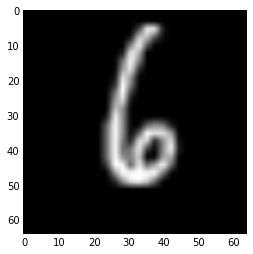

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(imb[0:1].reshape(64,64),'gray')

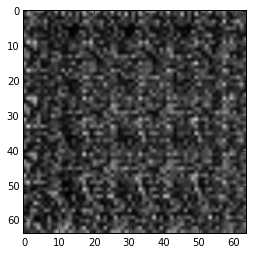

In [62]:
plt.imshow(np.asarray(_gen(np.asarray(_enc(imb[0:1])))).reshape(64,64),'gray')


In [64]:
_enc(imb[0:1]).shape

(1L, 100L)